# Role of elastic material properties and fault dip in the surface geodetic displacements

In this notebook, we explore the effect of the heterogeneous structure in the surface geodetic data.


In [1]:
# Load libraries
import dolfin as dl
import ufl
import math
import numpy as np
# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE-2)
plt.rc('ytick', labelsize=SMALL_SIZE-2)
plt.rc('legend', fontsize=TINY_SIZE+2)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp

# Make results reproducible
np.random.seed(seed=1)

# Set parameters compiler
dl.parameters["form_compiler"]["quadrature_degree"] = 5
dl.parameters["form_compiler"]["optimize"] = True
# Mute the FFC and UFL warnings
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)


In [2]:
# Define functions
# Define the compliance matrix for elasticity
def Asigma(s, mu, nu):
    A = 1./(2.*mu)*( s - nu/(1. + nu*(dim-2)) *ufl.tr(s)*ufl.Identity(dim) )
    return A

# Define the asymmetry operator
def asym(s): 
    as_ = s[0,1] - s[1,0]
    return as_

# Define the tangent operator
def T(n):
    T_operator = ufl.as_vector( [n[1], -n[0]] )
    return T_operator

# Class to define different properties in the subdomains with anomaly built-in
class K_Triangle(dl.UserExpression):
    def __init__(self, subdomains, k_0, k_1, **kwargs):
        super().__init__(**kwargs)
        self.subdomains = subdomains
        self.k_0 = k_0
        self.k_1 = k_1

    def eval_cell(self, values, x, cell):
        if self.subdomains[cell.index] == triangle_surface:
            values[0] = self.k_0
        else:
            values[0] = self.k_1
    
    def value_shape(self):
        return ()
        

In [3]:
# Mesh
meshpath = "../mesh/"
name = "Mesh_StraightFault_dip45_Triangle"
mesh = dl.Mesh(meshpath + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, meshpath + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, meshpath + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
blockleft = 7
blockright = 8
triangle_surface = 10
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

# Define sep
sep = "\n"+"#"*80+"\n"


In [4]:
# The linear coseismic inversion problem
# Define the weak formulation of the FORWARD problem
def pde_varf_mu(u, m, p):
    # Split the STATE and ADJOINT variables. Use dl.split() and not .split(deepcopy=True),
    # since the latter breaks FEniCS symbolic differentiation
    sigma, uu, r = dl.split(u)
    tau, w, q = dl.split(p)
    u0 = dl.Constant((0., 0.))
    # Define the weak formulation of the forward problem
    J = ufl.inner( Asigma(sigma, m, nu), tau )*ufl.dx \
        + ufl.inner( ufl.div(tau), uu )*ufl.dx \
        + ufl.inner( asym(tau), r )*ufl.dx \
        + ufl.inner( ufl.div(sigma), w )*ufl.dx + ufl.inner( asym(sigma), q )*ufl.dx \
        + ufl.inner( f, w )*dl.dx \
        - ufl.inner( u0, tau*n )*ds(bottom) \
        - ufl.inner( ufl.avg(slip), ufl.dot(  T(n('+')), tau('+')*n('+') ) )*dS(fault)
    return J


# The linear coseismic inversion problem
# Define the weak formulation of the FORWARD problem
def pde_varf_nu(u, m, p):
    # Split the STATE and ADJOINT variables. Use dl.split() and not
    # .split(deepcopy=True), since the latter breaks FEniCS symbolic differentiation
    sigma, uu, r = dl.split(u)
    tau, w, q = dl.split(p)
    u0 = dl.Constant((0., 0.))
    # Define the weak formulation of the forward problem
    J = ufl.inner( Asigma(sigma, mu, m), tau )*ufl.dx \
        + ufl.inner( ufl.div(tau), uu )*ufl.dx \
        + ufl.inner( asym(tau), r )*ufl.dx \
        + ufl.inner( ufl.div(sigma), w )*ufl.dx + ufl.inner( asym(sigma), q )*ufl.dx \
        + ufl.inner( f, w )*dl.dx \
        - ufl.inner( u0, tau*n )*ds(bottom) \
        - ufl.inner( ufl.avg(slip), ufl.dot(  T(n('+')), tau('+')*n('+') ) )*dS(fault)
    return J
    

In [5]:
# Define the function to solve the forward problem
def solveForwardProblem(k, mesh, m_a, m_b, PDE='mu'):

    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define function space for the model parameter (scalar), which is continuous
    Vm = dl.FunctionSpace(mesh, "CG", 1)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    print( sep, "Set up the mesh and finite element spaces", sep )
    print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
    print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )

    # Define the STATE and ADJOINT Dirichlet BCs
    zero_tensor = dl.Expression( (("0.", "0."), ("0.", "0.")), degree=0 )
    bc = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)
    bc0 = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)

    # Define the PDE problem
    if PDE == 'mu':
        pde = hp.PDEVariationalProblem(Vh, pde_varf_mu, bc, bc0, is_fwd_linear=True)
    elif PDE == 'nu':
        pde = hp.PDEVariationalProblem(Vh, pde_varf_nu, bc, bc0, is_fwd_linear=True)

    # Define the true model PARAMETER
    mtrue_expr = K_Triangle(subdomains, m_a, m_b, degree=0)
    mtrue = dl.interpolate(mtrue_expr, Vh[hp.PARAMETER]).vector()
    # Solve FORWARD problem for the STATE variables 
    utrue = pde.generate_state() # all dofs STATE variables and PETSC vector (not FEniCS Function)
    x = [utrue, mtrue, None]
    pde.solveFwd(x[hp.STATE], x)
    
    # Extract x,y coordinates of the fault for plotting
    bc1 = dl.DirichletBC(Vm, 10, boundaries, fault)
    um = dl.Function(Vm)
    bc1.apply(um.vector())
    # Extract x,y coordinates of the fault and values
    xslip = dl.interpolate(dl.Expression("x[0]", degree=5), Vm)
    yslip = dl.interpolate(dl.Expression("x[1]", degree=5), Vm)
    xf = xslip.vector()[um.vector() == 10] # x coordinate fault
    yf = yslip.vector()[um.vector() == 10] # y coordinate fault
    # Sort the values
    idx = np.argsort(xf)
    xf = xf[idx]; yf = yf[idx]

    # Extract the surface displacements
    # Interpolate in CG vector field
    CGv = dl.VectorFunctionSpace(mesh, "CG", k)
    u_true = dl.Function(Vh[hp.STATE].sub(1), utrue)
    usCG = dl.interpolate(u_true, CGv)
    coor = CGv.tabulate_dof_coordinates()
    # Takes both the horizontal and vertical surface displacements
    Xustrue = []; Ustrue = []
    Xstrue = []; Usxtrue = []; Usytrue = []
    j = 0
    for i, x in enumerate(coor):
        if x[1] == 0: # take only the surface
            # Save both x and us true
            Xustrue.append(x[0])
            Ustrue.append(usCG.vector()[i])
            # Save the different components
            if (j % 2) == 0:
                Xstrue.append(x[0])
                Usxtrue.append(usCG.vector()[i])
            else:
                Usytrue.append(usCG.vector()[i])
            j = j+1
    # Sort them
    idx = sorted(range(len(Xstrue)), key=lambda k: Xstrue[k])
    xstrue = []; usxtrue = []; usytrue = []
    for i in range(0, len(Xstrue)):
        xstrue.append(Xstrue[idx[i]])
        usxtrue.append(Usxtrue[idx[i]])
        usytrue.append(Usytrue[idx[i]])
    # Convert in numpy array
    xstrue = np.array(xstrue) 
    usxtrue = np.array(usxtrue) 
    usytrue = np.array(usytrue)
    
    # Convert from m to shear modulus
    m_true = hp.vector2Function(mtrue, Vh[hp.PARAMETER])    
    
    return( mesh, Vh, xf, yf, utrue, m_true, xstrue, usxtrue, usytrue )
    

In [6]:
### DEFINE COMMON PARAMETERS ###
# Define order of elements (k = 1 --> linear; k = 2 --> quadratic)
k = 2
# Define body force
f = dl.Constant((0., 0.))
# Define the true model PARAMETER
GPa2Pa = 1e9
mu = 30e9  
nu = 0.25                
# Define the expression for fault slip
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-30., std=30., degree=5)


In [7]:
# Calculate material parameters
E = 2*mu * (1 + nu)
print( "The background parameters are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu/GPa2Pa, E/GPa2Pa, nu) )


The background parameters are: mu = 30.00 GPa; E = 75.00 GPa; nu = 0.25


In [8]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Blues")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-0.5, 0.5, 21)
levels_uy = np.linspace(-0.5, 0.5, 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]

from matplotlib.patches import Polygon
import matplotlib.patches as patches
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)


In [9]:
# Define data noise and regularization weights 
E = 2*mu * (1 + nu)
print( "The background parameters are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu/GPa2Pa, E/GPa2Pa, nu) )

# Solve the inverse problem
( mesh, Vh, xf_1, yf_1, utrue_1, mtrue_1, xstrue_1, usxtrue_1, usytrue_1 ) = solveForwardProblem(k, mesh, mu, mu, PDE='mu')


The background parameters are: mu = 30.00 GPa; E = 75.00 GPa; nu = 0.25

################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=2380, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842


In [10]:
# Choose a shear modulus anomaly
mu_a2 = 15e9
# Calculate the other material parameters
E_a2 = 2*mu_a2 * (1 + nu)
print( "The parameters for the anomaly are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu_a2/GPa2Pa, E_a2/GPa2Pa, nu) )

# Solve the inverse problem
( _, _, _, _, utrue_11, mtrue_11, xstrue_11, usxtrue_11, usytrue_11 ) = solveForwardProblem(k, mesh, mu_a2, mu, PDE='mu')


The parameters for the anomaly are: mu = 15.00 GPa; E = 37.50 GPa; nu = 0.25

################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=2380, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842


In [11]:
# Choose a shear modulus anomaly
mu_a3 = 45e9
# Calculate the other material parameters
E_a3 = 2*mu_a3 * (1 + nu)
print( "The parameters for the anomaly are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu_a3/GPa2Pa, E_a3/GPa2Pa, nu) )

# Solve the inverse problem
( _, _, _, _, utrue_12, mtrue_12, xstrue_12, usxtrue_12, usytrue_12 ) = solveForwardProblem(k, mesh, mu_a3, mu, PDE='mu')


The parameters for the anomaly are: mu = 45.00 GPa; E = 112.50 GPa; nu = 0.25

################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=2380, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842


In [12]:
# Choose a Poisson's ratio anomaly
nu_a1_nu = nu
# Calculate the other material parameters
E_a1_nu = 2*mu * (1 + nu_a1_nu)
print( "The parameters for the anomaly are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu/GPa2Pa, E_a1_nu/GPa2Pa, nu_a1_nu) )

( mesh, Vh, xf_1, yf_1, utrue_15, mtrue_15, xstrue_15, usxtrue_15, usytrue_15 ) = solveForwardProblem(k, mesh, nu_a1_nu, nu, PDE='nu')


# Choose a Poisson's ratio anomaly
nu_a2_nu = 0.05
# Calculate the other material parameters
E_a2_nu = 2*mu * (1 + nu_a2_nu)
print( "The parameters for the anomaly are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu/GPa2Pa, E_a2_nu/GPa2Pa, nu_a2_nu) )

( mesh, Vh, xf_1, yf_1, utrue_16, mtrue_16, xstrue_16, usxtrue_16, usytrue_16 ) = solveForwardProblem(k, mesh, nu_a2_nu, nu, PDE='nu')


# Choose a Poisson's ratio anomaly
nu_a3_nu = 0.35
# Calculate the other material parameters
E_a3_nu = 2*mu * (1 + nu_a3_nu)
print( "The parameters for the anomaly are: mu = %.2f GPa; E = %.2f GPa; nu = %.2f" %(mu/GPa2Pa, E_a3_nu/GPa2Pa, nu_a3_nu) )

( mesh, Vh, xf_1, yf_1, utrue_17, mtrue_17, xstrue_17, usxtrue_17, usytrue_17 ) = solveForwardProblem(k, mesh, nu_a3_nu, nu, PDE='nu')


The parameters for the anomaly are: mu = 30.00 GPa; E = 75.00 GPa; nu = 0.25

################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=2380, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842
The parameters for the anomaly are: mu = 30.00 GPa; E = 63.00 GPa; nu = 0.05

################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=2380, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842
The parameters for the anomaly are: mu = 30.00 GPa; E = 81.00 GPa; nu = 0.35

################################################################

In [13]:
# Mesh
name = "Mesh_StraightFault_dip60_Triangle"
mesh_2 = dl.Mesh(meshpath + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh_2.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh_2)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh_2, meshpath + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh_2, meshpath + name + '_physical_region.xml')
ds = dl.Measure('ds')(domain=mesh_2, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh_2, subdomain_data=boundaries)


# Define data noise and regularization weights
# Solve the inverse problem
( mesh_2, Vh, xf_2, yf_2, utrue_2, mtrue_2, xstrue_2, usxtrue_2, usytrue_2 ) = solveForwardProblem(k, mesh_2, mu, mu, PDE='mu')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=115872, PARAMETER=2478, ADJOINT=115872
Number of STATE and ADJOINT dofs: STRESS=72582, DISPLACEMENT=28860, ROTATION=14430


In [14]:
# Mesh
name = "Mesh_StraightFault_dip30_Triangle"
mesh_3 = dl.Mesh(meshpath + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh_3.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh_3)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh_3, meshpath + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh_3, meshpath + name + '_physical_region.xml')
ds = dl.Measure('ds')(domain=mesh_3, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh_3, subdomain_data=boundaries)

# Define data noise and regularization weights
# Solve the inverse problem
( mesh_3, Vh, xf_3, yf_3, utrue_3, mtrue_3, xstrue_3, usxtrue_3, usytrue_3 ) = solveForwardProblem(k, mesh_3, mu, mu, PDE='mu')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=98784, PARAMETER=2122, ADJOINT=98784
Number of STATE and ADJOINT dofs: STRESS=61902, DISPLACEMENT=24588, ROTATION=12294


In [15]:
# Create class for legend two markers with same label
from matplotlib.legend_handler import HandlerBase

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        if orig_handle[2] != " " and orig_handle[3] != " " :
            l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], linestyle=orig_handle[1], color=orig_handle[0])
            l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], linestyle=orig_handle[3], color=orig_handle[2])
            return [l1, l2]
        else:
            l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height], linestyle=orig_handle[1], color=orig_handle[0], linewidth=2.0)
            return [l1]
            

# Plot

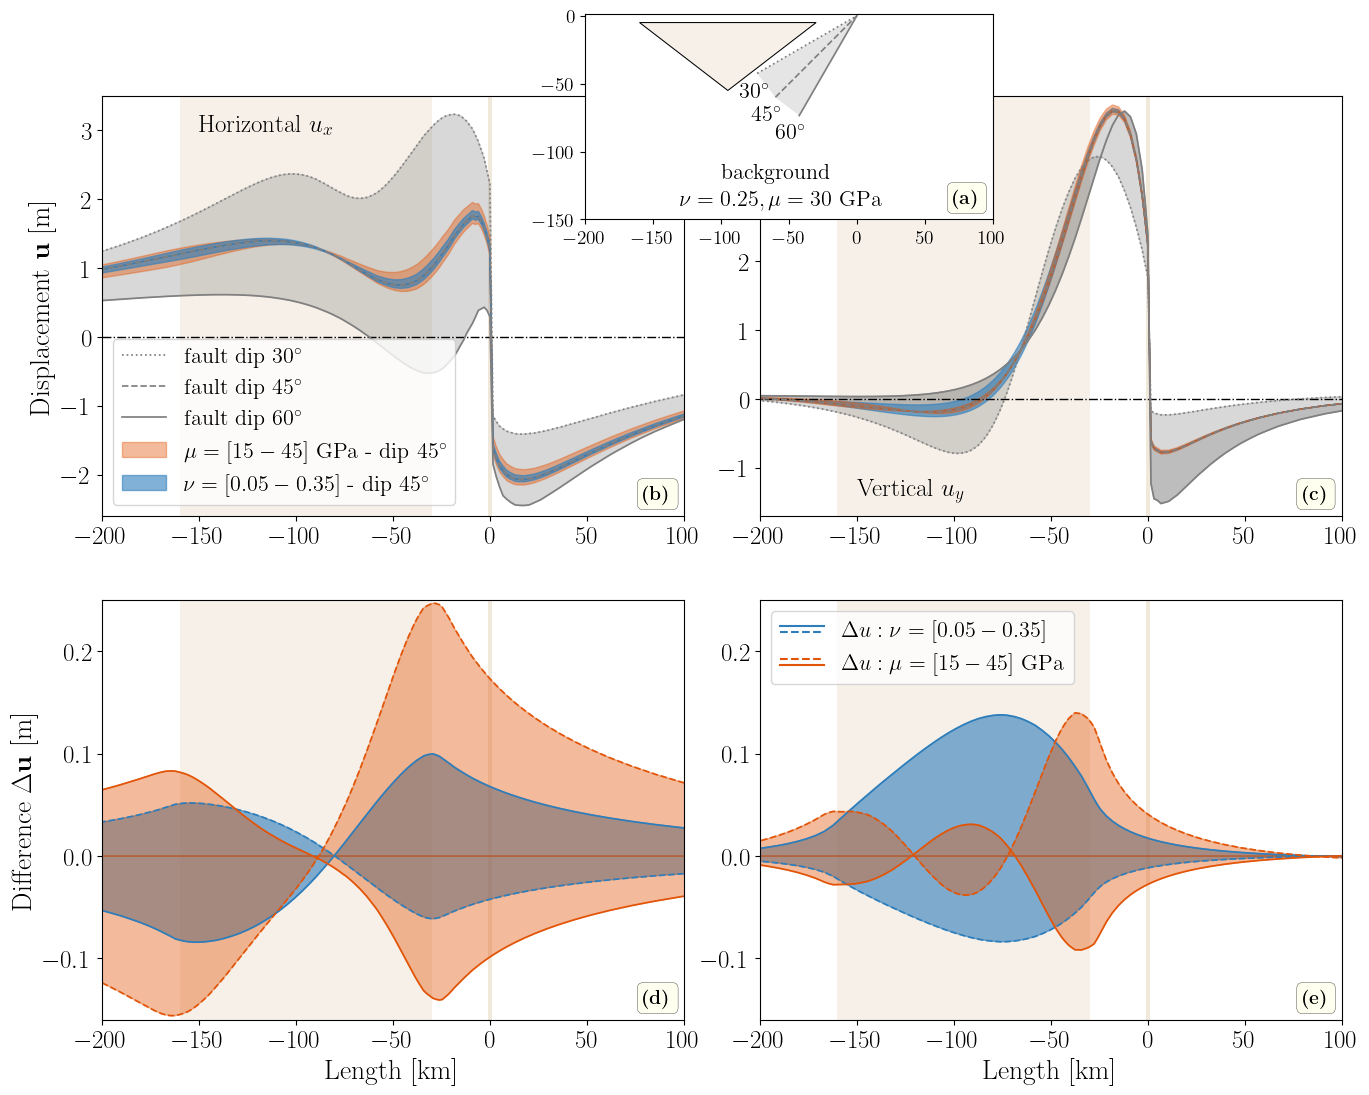

In [16]:
cmap = plt.get_cmap("Oranges_r")
cmap_1 = plt.get_cmap("Blues_r")
# dip, mu, nu, triangle, rest
colors = ['gray', cmap(0.3), cmap_1(0.3), 'tan', 'black']
# dip, mu, nu, triangle, fault
alphas = [0.3, 0.4, 0.6, 0.2, 0.3]
linestyles = ["dotted", "dashed", "solid"]
lww = 1.25


# Plot the results
fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2,4)
gs.update(wspace=0.3, hspace=0.2)

# Plot top left
ax1 = plt.subplot(gs[0, :2],)
ax1.plot(xstrue_1, np.zeros(len(xstrue_1)), '-.', color=colors[4], lw=1.)
ax1.add_patch( Rectangle( (-160,-3),130,10, facecolor=colors[3], alpha=alphas[3] ) )
ax1.add_patch( Rectangle( (-1,-3),2,10, facecolor=colors[3], alpha=alphas[4] ) )
p4 = ax1.plot(xstrue_3, usxtrue_3, ls=linestyles[0], color=colors[0], 
              lw=lww, label=r"fault dip $30^\circ$", zorder=2)
p5 = ax1.plot(xstrue_1, usxtrue_1, ls=linestyles[1], color=colors[0], 
              lw=lww, label=r"fault dip $45^\circ$", zorder=2)
p6 = ax1.plot(xstrue_2, usxtrue_2, ls=linestyles[2], color=colors[0], 
              lw=lww, label=r"fault dip $60^\circ$", zorder=2)
ax1.annotate(r"Horizontal $u_x$", xy=(-150,3), fontsize=18)
ax1.set_xlim((lef, rig))
ax1.set_ylim((-2.6, 3.5))
ax1.set_ylabel(r"Displacement $\mathbf{u}$ [m]")
ax1.fill_between( xstrue_1, usxtrue_2, usxtrue_3, color=colors[0], alpha=alphas[0] )
ax1.fill_between( xstrue_1, usxtrue_12, usxtrue_1, color=colors[1], alpha=alphas[1], 
                 label=r"$\mathrm{\mu} = [15-45]$ GPa - dip $45^\circ$" )
ax1.fill_between( xstrue_1, usxtrue_11, usxtrue_1, color=colors[1], alpha=alphas[1] )
ax1.fill_between( xstrue_1, usxtrue_17, usxtrue_15, color=colors[2], alpha=alphas[2], 
                 label=r"$\mathrm{\nu} = [0.05-0.35]$ - dip $45^\circ$" )
ax1.fill_between( xstrue_1, usxtrue_16, usxtrue_15, color=colors[2], alpha=alphas[2] )
ax1.legend(loc='lower left')
ax1.text(0.93, 0.075, r'\textbf{(b)}', transform=ax1.transAxes, fontsize=TINY_SIZE,
        verticalalignment='top', bbox=props)


# Plot top right
ax2 = plt.subplot(gs[0, 2:])
ax2.plot(xstrue_1, np.zeros(len(xstrue_1)), '-.', color=colors[4], lw=1.)
ax2.add_patch( Rectangle( (-160,-3),130,10, facecolor=colors[3], alpha=alphas[3] ) )
ax2.add_patch( Rectangle( (-1,-3),2,10, facecolor=colors[3], alpha=alphas[4] ) )
p1 = ax2.plot(xstrue_3, usytrue_3, ls=linestyles[0], color=colors[0], lw=lww)
p2 = ax2.plot(xstrue_1, usytrue_1, ls=linestyles[1], color=colors[0], lw=lww)
p3 = ax2.plot(xstrue_2, usytrue_2, ls=linestyles[2], color=colors[0], lw=lww)
ax2.annotate(r"Vertical $u_y$", xy=(-150,-1.4), fontsize=18)
ax2.set_xlim((lef, rig))
ax2.set_ylim((-1.7, 4.4))
ax2.fill_between( xstrue_1, usytrue_2, usytrue_3, color=colors[0], alpha=alphas[0] )
ax2.fill_between( xstrue_1, usytrue_2, usytrue_1, color=colors[0], alpha=alphas[0] )
ax2.fill_between( xstrue_1, usytrue_17, usytrue_15, color=colors[2], alpha=alphas[2] )
ax2.fill_between( xstrue_1, usytrue_16, usytrue_15, color=colors[2], alpha=alphas[2] )
ax2.fill_between( xstrue_1, usytrue_12, usytrue_1, color=colors[1], alpha=alphas[1] )
ax2.fill_between( xstrue_1, usytrue_11, usytrue_1, color=colors[1], alpha=alphas[1] )
ax2.text(0.9325, 0.075, r'\textbf{(c)}', transform=ax2.transAxes, fontsize=TINY_SIZE,
        verticalalignment='top', bbox=props)

# Inset
axins = ax2.inset_axes([-0.3, 0.7, 0.7, 0.5])
axins.plot(xf_1, yf_1, color=colors[0], ls=linestyles[1], lw=lww)
axins.plot(xf_2, yf_2, color=colors[0], ls=linestyles[2], lw=lww)
axins.plot(xf_3, yf_3, color=colors[0], ls=linestyles[0], lw=lww)
xy_polygon = np.array([ [xf_1[-1],yf_1[-1]], [xf_2[0],yf_2[0]], [xf_1[0],yf_1[0]], [xf_3[0],yf_3[0]] ])
axins.add_patch(Polygon(xy_polygon, facecolor=colors[0], edgecolor='none', linestyle="-", lw=lww, alpha=alphas[3]))
axins.set_xlim((lef, rig)) 
axins.set_ylim((bot, top))
axins.add_patch(Polygon(xy_triangle, facecolor=colors[3], edgecolor="none", alpha=alphas[3]))
axins.add_patch(Polygon(xy_triangle, facecolor="none", edgecolor=colors[4], linestyle="-", lw=0.75))
axins.text(-100, -120, r"background", fontsize=16)
axins.text(-130, -140, r"$\nu = %.2f, \mu = %d$ GPa" %(nu, mu/GPa2Pa), fontsize=16)
axins.text(-87, -60, r"$30^\circ$", fontsize=16)
axins.text(-78, -77, r"$45^\circ$", fontsize=16)
axins.text(-60, -90, r"$60^\circ$", fontsize=16)
axins.set_aspect('equal')
axins.tick_params(axis='both', which='major', direction='out', labelsize=14)
axins.tick_params(axis='both', which='minor', direction='out', labelsize=12)
axins.text(1.4625, 0.78, r'\textbf{(a)}', transform=ax1.transAxes, fontsize=TINY_SIZE,
        verticalalignment='top', bbox=props)


# Plot bottom left
ax3 = plt.subplot(gs[1, :2])
ax3.add_patch( Rectangle( (-160,-2.3),130,6, facecolor=colors[3], alpha=alphas[3] ) )
ax3.add_patch( Rectangle( (-1,-2.3),2,6, facecolor=colors[3], alpha=alphas[4] ) )
ax3.plot(xstrue_1,(usxtrue_16-usxtrue_1), ls=linestyles[2], color=colors[2], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\nu} = %.2f$" %(nu_a2_nu) )
ax3.plot(xstrue_1,(usxtrue_17-usxtrue_1), ls=linestyles[1], color=colors[2], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\nu} = %.2f$" %(nu_a3_nu) )
ax3.plot(xstrue_1,(usxtrue_11-usxtrue_1), ls=linestyles[1], color=colors[1], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\mu} = %d$ GPa" %(mu_a2/GPa2Pa) )
ax3.plot(xstrue_1,(usxtrue_12-usxtrue_1), ls=linestyles[2], color=colors[1], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\mu} = %d$ GPa" %(mu_a3/GPa2Pa) )
ax3.fill_between( xstrue_1, usxtrue_17 - usxtrue_1, color=colors[2], alpha=alphas[2] )
ax3.fill_between( xstrue_1, usxtrue_16 - usxtrue_1, color=colors[2], alpha=alphas[2] )
ax3.fill_between( xstrue_1, usxtrue_12 - usxtrue_1, color=colors[1], alpha=alphas[1] )
ax3.fill_between( xstrue_1, usxtrue_11 - usxtrue_1, color=colors[1], alpha=alphas[1] )
ax3.set_xlim((lef, rig))
ax3.set_ylim((-0.16, 0.25))
ax3.set_ylabel(r"Difference $\Delta \mathbf{u}$ [m]")
ax3.set_xlabel(r"Length [km]")
ax3.text(0.93, 0.075, r'\textbf{(d)}', transform=ax3.transAxes, fontsize=TINY_SIZE,
        verticalalignment='top', bbox=props)


# Plot bottom right
ax4 = plt.subplot(gs[1, 2:])
ax4.add_patch( Rectangle( (-160,-2.3),130,6, facecolor=colors[3], alpha=alphas[3] ) )
ax4.add_patch( Rectangle( (-1,-2.3),2,6, facecolor=colors[3], alpha=alphas[4] ) )
ax4.plot(xstrue_1,(usytrue_16-usytrue_1), ls=linestyles[2], color=colors[2], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\nu} = %.2f$" %(nu_a2_nu) )
ax4.plot(xstrue_1,(usytrue_17-usytrue_1), ls=linestyles[1], color=colors[2], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\nu} = %.2f$" %(nu_a3_nu) )
ax4.plot(xstrue_1,(usytrue_11-usytrue_1), ls=linestyles[1], color=colors[1], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\mu} = %d$ GPa" %(mu_a2/GPa2Pa) )
ax4.plot(xstrue_1,(usytrue_12-usytrue_1), ls=linestyles[2], color=colors[1], 
         lw=lww, label=r"$\Delta u$: $\mathrm{\mu} = %d$ GPa" %(mu_a3/GPa2Pa) )
ax4.fill_between( xstrue_1, usytrue_17 - usytrue_15, color=colors[2], alpha=alphas[2] )
ax4.fill_between( xstrue_1, usytrue_16 - usytrue_15, color=colors[2], alpha=alphas[2] )
ax4.fill_between( xstrue_1, usytrue_12 - usytrue_1, color=colors[1], alpha=alphas[1] )
ax4.fill_between( xstrue_1, usytrue_11 - usytrue_1, color=colors[1], alpha=alphas[1] )
ax4.legend([(colors[2],linestyles[2], colors[2],linestyles[1]), 
            (colors[1],linestyles[1], colors[1],linestyles[2])], 
           [r"$\Delta u: \mathrm{\nu} = [0.05-0.35]$", 
            r"$\Delta u: \mathrm{\mu} = [15-45]$ GPa"], 
           handler_map={tuple: AnyObjectHandler()}, loc='upper left')
ax4.set_xlim((lef, rig))
ax4.set_ylim((-0.16, 0.25)) 
ax4.set_xlabel(r"Length [km]")
ax4.text(0.9325, 0.075, r'\textbf{(e)}', transform=ax4.transAxes, fontsize=TINY_SIZE,
        verticalalignment='top', bbox=props)

plt.show()